<a href="https://colab.research.google.com/github/alicewang777/INDE577_ML_Rice_2025/blob/master/Supervised_Learning/1.%20Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The perceptron**
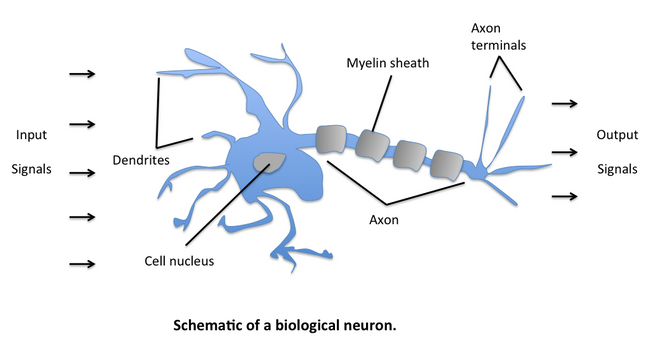


The Perceptrons motivation came from a neuron in the brain. It can be perceived as a cell which receives an input and outputs a signal. By continuously increasing or decreasing the weights depending on what the Perceptrons output was after each training example or a set of training examples the predictions become more accurate.

The perceptron is a single neuron model with the *sign* activation function as depicted in the figure below.

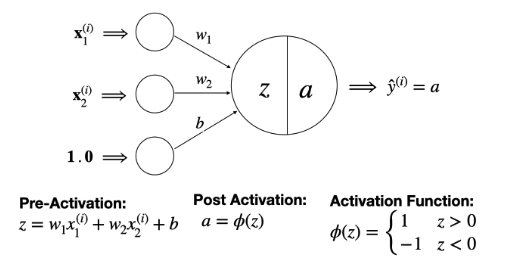

In [16]:
%%capture
# Step 1: Clone your GitHub repo
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

# Step 2: Add the package path to sys.path
import sys
sys.path.append('/content/INDE577_ML_Rice_2025')

# Step 3: Try importing your model
from rice_ml.perceptron import Perceptron

# Step 4: Confirm it's working
print("Perceptron loaded ✅")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd


csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"

df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


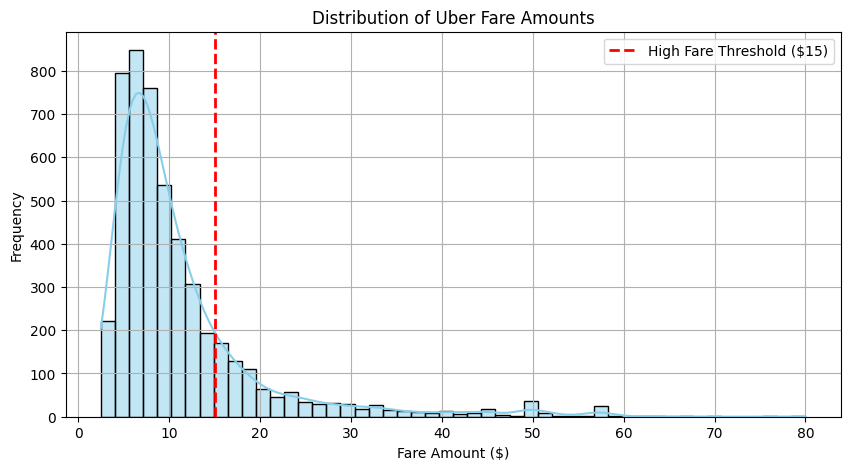

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['fare_amount'], bins=50, kde=True, color="skyblue")

plt.axvline(x=15, color='red', linestyle='--', linewidth=2, label='High Fare Threshold ($15)')
plt.title("Distribution of Uber Fare Amounts")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
import plotly.express as px

In [37]:
df_map = df.sample(n=1000, random_state=42)

fig = px.scatter_mapbox(
    df_map,
    lat="pickup_latitude",
    lon="pickup_longitude",
    color="fare_amount",
    size_max=8,
    zoom=10,
    mapbox_style="carto-positron",
    title="📍 Uber Pickup Locations Colored by Fare Amount",
    color_continuous_scale="YlOrRd"
)

fig.show()

In [38]:
import folium
from folium.plugins import HeatMap

center_lat = df['pickup_latitude'].mean()
center_lon = df['pickup_longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

heat_data = df[['pickup_latitude', 'pickup_longitude']].dropna().sample(n=1000).values.tolist()

HeatMap(heat_data).add_to(m)

m

Test Accuracy: 0.9030
Precision:     0.7826
Recall:        0.6171


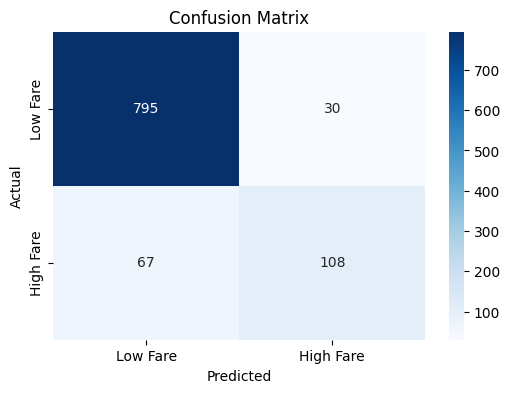


Top Predictors (by absolute weight):
manhattan_distance       : 0.1075
pickup_latitude          : 0.0411
dropoff_longitude        : -0.0233
pickup_longitude         : -0.0167
dayofweek                : 0.0011
hour_exact_x_passenger   : -0.0010
passenger_count          : 0.0009
dropoff_latitude         : 0.0009
is_weekend               : -0.0006
hour_exact               : -0.0001


In [40]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from rice_ml.perceptron import Perceptron
from rice_ml.metrics import accuracy

# Step 1: Load & Clean Data
df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()

# Step 2: Feature Engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['hour_exact_x_passenger'] = df['hour_exact'] * df['passenger_count']
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

# Step 3: Create Label
df = df[df['fare_amount'] < 100]
df['label'] = (df['fare_amount'] > 15).astype(int)

# Step 4: Sample for speed
df = df.sample(n=5000, random_state=42)

# Step 5: Select Features + Scale
features = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'hour_exact', 'dayofweek', 'is_weekend',
    'hour_exact_x_passenger', 'manhattan_distance'
]
X_raw = df[features].values
y = df['label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Train on Raw Training Set (No Resampling)
model = Perceptron(learning_rate=0.0005, n_iters=2000)
model.fit(X_train, y_train)

# Step 8: Predict & Evaluate
y_pred = model.predict(X_test)
acc = accuracy(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)

print(f"Test Accuracy: {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low Fare", "High Fare"],
            yticklabels=["Low Fare", "High Fare"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 10: Feature Importance
weights = model.weights
top_features = sorted(zip(features, weights), key=lambda x: abs(x[1]), reverse=True)

print("\nTop Predictors (by absolute weight):")
for name, w in top_features:
    print(f"{name:<25}: {w:.4f}")